In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, hidden_dim=128, latent_dim=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)  # Mean of the latent space
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)  # Log-variance of the latent space

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

In [ ]:
# Reparameterization Trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

In [ ]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self, hidden_dim=128, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_reconstructed = torch.sigmoid(self.fc2(h))  # Output layer
        return x_reconstructed

In [ ]:
# VAE Network combining Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, hidden_dim=128, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_dim, latent_dim)
        self.decoder = Decoder(hidden_dim, latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 784))  # Flatten input
        z = reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


In [ ]:
# Loss function: Reconstruction loss + KL Divergence
def loss_function(reconstructed_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    # KL divergence loss
    # Assuming the prior is a standard normal distribution
    # KL divergence between N(mu, sigma^2) and N(0, 1)
    # KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 is exp(logvar)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return BCE + KL

In [ ]:
# Train the VAE
def train_vae(model, data_loader, epochs=10, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            x, _ = batch
            x = x.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed_x, mu, logvar = model(x)

            # Compute loss
            loss = loss_function(reconstructed_x, x, mu, logvar)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(data_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [ ]:
# Visualization
def plot_latent_space(model, data_loader):
    model.eval()
    with torch.no_grad():
        latent_points = []
        labels = []

        for batch in data_loader:
            x, y = batch
            x = x.to(device)
            mu, _ = model.encoder(x.view(-1, 784))  # Get the mean of the latent space
            latent_points.append(mu.cpu().numpy())
            labels.append(y.cpu().numpy())

        latent_points = np.concatenate(latent_points, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Plot the latent space
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', s=10)
        plt.colorbar()
        plt.title("Latent Space Representation")
        plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.28MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 207.2670
Epoch 2/10, Loss: 176.4248
Epoch 3/10, Loss: 170.5472
Epoch 4/10, Loss: 167.2999
Epoch 5/10, Loss: 165.0516
Epoch 6/10, Loss: 163.4098
Epoch 7/10, Loss: 162.1988
Epoch 8/10, Loss: 161.1409
Epoch 9/10, Loss: 160.3153
Epoch 10/10, Loss: 159.5960


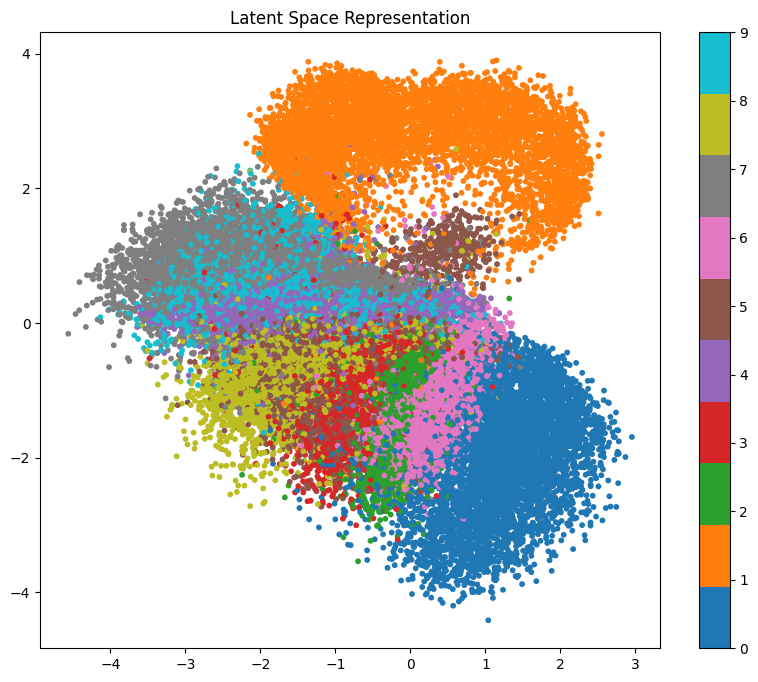

In [ ]:
# Main code for training and plotting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST data
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Initialize and train VAE model
vae = VAE().to(device)
train_vae(vae, train_loader)

# Plot latent space
plot_latent_space(vae, train_loader)

In [ ]:
def plot_class_latents(model, data_loader, digits=[0, 1, 9], num_samples=100):
    model.eval()
    latent_points = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, y = batch
            # Check for labels in the batch that belong to the digits of interest
            mask = torch.isin(y, torch.tensor(digits).to(device))  # Create a mask for the selected digits
            x_selected = x[mask]  # Select the images corresponding to the selected digits
            y_selected = y[mask]  # Select the labels corresponding to the selected digits

            # Pass the selected images through the encoder to get the latent variables (mu)
            mu, _ = model.encoder(x_selected.view(-1, 784).to(device))  # Flatten the input

            latent_points.append(mu.cpu().numpy())
            labels.append(y_selected.cpu().numpy())

            if len(latent_points) >= num_samples:
                break

        # Convert lists to numpy arrays
        latent_points = np.concatenate(latent_points, axis=0)
        labels = np.concatenate(labels, axis=0)

    # Plotting the latent space
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar()
    plt.title("Latent Space Representation of Digits 0, 1, and 9")
    plt.show()


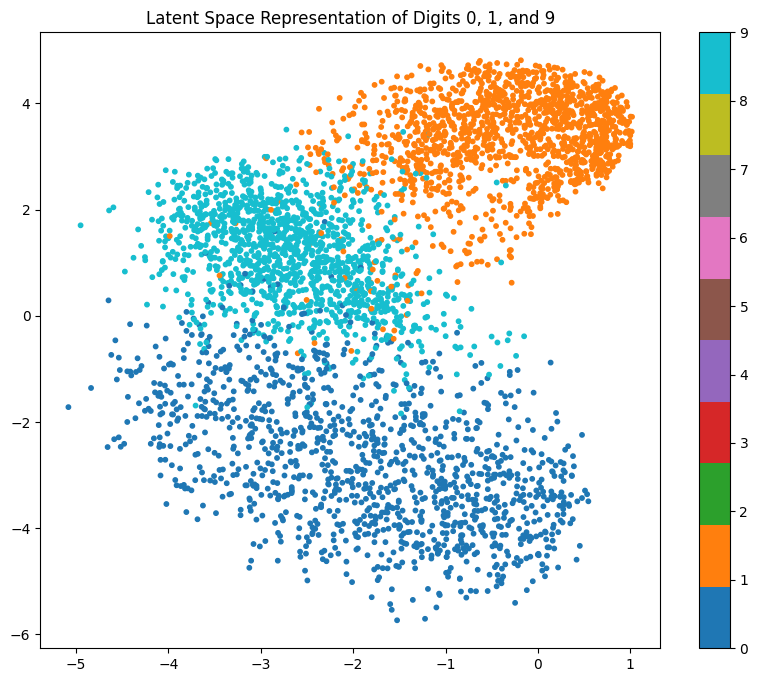

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Plot latent space for digits 0, 1, and 9
plot_class_latents(vae, train_loader, digits=[0, 1, 9], num_samples=100)